<a href="https://colab.research.google.com/github/nagusubra/Solar_panel_dust_detection/blob/main/Solar_panel_dust_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Install libraries and modules

In [3]:
!pip install -q tensorflow-model-optimization

import tempfile
from tensorflow import keras
import tensorflow_model_optimization as tfmot

from tqdm import tqdm_notebook as tqdm
import os
import time
import pickle
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 238.9/238.9 KB 18.1 MB/s eta 0:00:00


In [4]:
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dense, Flatten, BatchNormalization, Dropout
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.utils import plot_model
from tensorflow.keras.losses import binary_crossentropy
from sklearn.model_selection import cross_val_score

import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import datetime

In [5]:
# mounting google drive (if you are using Colab)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# from os import listdir
# from os.path import isfile, join

# mypath = '/content/drive/MyDrive/Solar_panel_dust_detection/dataset_2/dirty'

# onlyfiles = [ f  for f in listdir(mypath) if isfile(join(mypath, f))]

# onlyfiles

In [15]:
# from os import listdir
# from os.path import isfile, join

# mypath = '/content/drive/MyDrive/Solar_panel_dust_detection/dataset_2/dirty'

# onlyfiles = [ os.rename(join(mypath, f), join(mypath, f.split(".")[0] + "_dirty" + ".jpg"))  for f in listdir(mypath) if isfile(join(mypath, f))]

# onlyfiles

# Build base model

In [16]:
def SolNet(in_size):
  i = Input(in_size)
  r = Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(227,227,3))(i)
  r = BatchNormalization()(r)
  r = MaxPooling2D(pool_size=(3,3), strides=(2,2))(r)
  r = Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same")(r)
  r = BatchNormalization()(r)
  r = MaxPooling2D(pool_size=(3,3), strides=(2,2))(r)
  r = Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same")(r)
  r = BatchNormalization()(r)
  r = Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same")(r)
  r = BatchNormalization()(r)
  r = Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same")(r)
  r = BatchNormalization()(r)
  r = MaxPooling2D(pool_size=(3,3), strides=(2,2))(r)
  r = Flatten()(r)
  r = Dense(4096, activation='relu')(r)
  r = Dropout(0.5)(r)
  r = Dense(4096, activation='relu')(r)
  r = Dropout(0.5)(r)
  o = Dense(1, activation='sigmoid')(r)
  SolNet = Model(i, o)
  SolNet.save('models/solnet.hdf5')
  SolNet.compile(optimizer=Adam(.0001, .8, .9), loss=binary_crossentropy, metrics=['acc'])
  SolNet.summary()
  return SolNet

#Base Model

In [17]:
def SolNet(in_size):
  i = Input(in_size)
  r = Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(227,227,3))(i)
  r = BatchNormalization()(r)
  r = MaxPooling2D(pool_size=(3,3), strides=(2,2))(r)
  r = Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same")(r)
  r = BatchNormalization()(r)
  r = MaxPooling2D(pool_size=(3,3), strides=(2,2))(r)
  r = Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same")(r)
  r = BatchNormalization()(r)
  r = Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same")(r)
  r = BatchNormalization()(r)
  r = Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same")(r)
  r = BatchNormalization()(r)
  r = MaxPooling2D(pool_size=(3,3), strides=(2,2))(r)
  r = Flatten()(r)
  r = Dense(4096, activation='relu')(r)
  r = Dropout(0.5)(r)
  r = Dense(4096, activation='relu')(r)
  r = Dropout(0.5)(r)
  o = Dense(1, activation='sigmoid')(r)
  SolNet = Model(i, o)
  SolNet.save('models/solnet.hdf5')
  SolNet.save('/content/drive/MyDrive/Solar_panel_dust_detection/models/solnet'+str(datetime.datetime.today().date())+'.hdf5')
  SolNet.save('/content/drive/MyDrive/Solar_panel_dust_detection/models/solnet'+str(datetime.datetime.today().date())+'.h5')
  SolNet.compile(optimizer=Adam(.0001, .8, .9), loss=binary_crossentropy, metrics=['acc'])
  SolNet.summary()
  return SolNet

In [18]:
def evaluate():
  path = "/content/models/solnet.hdf5"
  solnet = load_model(path, compile=False)
  # history = solnet.history()
  plt.plot(history.history['loss'])
  plt.plot(history.history['acc'])
  plt.title('acc loss vs epoch')
  plt.xlabel('epoch')
  plt.legend(['loss', 'acc'], loc='upper left')
  plt.show()

In [19]:
# Evaluate Model Size
def get_gzipped_model_size(file):
  # Returns size of gzipped model, in bytes.
  import os
  import zipfile

  _, zipped_file = tempfile.mkstemp('.zip')
  with zipfile.ZipFile(zipped_file, 'w', compression=zipfile.ZIP_DEFLATED) as f:
    f.write(file)

  return os.path.getsize(zipped_file)

In [20]:
batch_size = 32
#location = 'dataset/'
location = "/content/drive/MyDrive/Solar_panel_dust_detection/dataset_1"
label_mode = 'binary'
seed = 10 #changed for each fold made manually
epochs=30
#epochs=5


class_names = ['clean', 'dirty']
in_size = [227, 227, 3]

tr_dataset = image_dataset_from_directory(directory=location, label_mode= label_mode, class_names=class_names,
                                          seed=seed, labels='inferred', image_size=in_size[:-1], 
                                          subset = 'training', batch_size=batch_size, validation_split=.2)

val_dataset = image_dataset_from_directory(directory=location, label_mode= label_mode, class_names=class_names,
                                          seed=seed, labels='inferred', image_size=in_size[:-1],
                                          subset = 'validation', batch_size=batch_size, validation_split=.2)

in_size = [227, 227, 3]
SolNet = SolNet(in_size)



startTime = time.time()
history = SolNet.fit(tr_dataset, validation_data=val_dataset, epochs=epochs, batch_size=batch_size)
executionTime = (time.time() - startTime)

Found 1440 files belonging to 2 classes.
Using 1152 files for training.
Found 1440 files belonging to 2 classes.
Using 288 files for validation.


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 227, 227, 3)]     0         
                                                                 
 conv2d_10 (Conv2D)          (None, 55, 55, 96)        34944     
                                                                 
 batch_normalization_10 (Bat  (None, 55, 55, 96)       384       
 chNormalization)                                                
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 27, 27, 96)       0         
 2D)                                                             
                                                                 
 conv2d_11 (Conv2D)          (None, 27, 27, 256)       614656    
                                                                 
 batch_normalization_11 (Bat  (None, 27, 27, 256)      1024

In [21]:
print(history.history)

{'loss': [1.3287363052368164, 0.5634193420410156, 0.5111455321311951, 0.4731604754924774, 0.4032560884952545, 0.3881598711013794, 0.31916534900665283, 0.17050495743751526, 0.13634862005710602, 0.18331176042556763, 0.13211464881896973, 0.2388705164194107, 0.13867801427841187, 0.13399434089660645, 0.26728636026382446, 0.10856659710407257, 0.1045788899064064, 0.21800419688224792, 0.18994426727294922, 0.13771790266036987, 0.05984649434685707, 0.13090425729751587, 0.08103565126657486, 0.14808224141597748, 0.16438354551792145, 0.07622100412845612, 0.0836929902434349, 0.04517742618918419, 0.0693543553352356, 0.06658089905977249], 'acc': [0.7508680820465088, 0.8680555820465088, 0.8871527910232544, 0.8932291865348816, 0.9166666865348816, 0.9296875, 0.9348958134651184, 0.9618055820465088, 0.9713541865348816, 0.9670138955116272, 0.9704861044883728, 0.9609375, 0.9826388955116272, 0.9704861044883728, 0.9722222089767456, 0.9809027910232544, 0.9809027910232544, 0.9661458134651184, 0.9800347089767456,

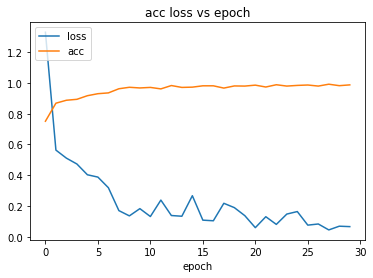

In [22]:
evaluate()

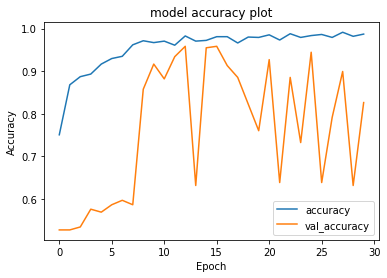

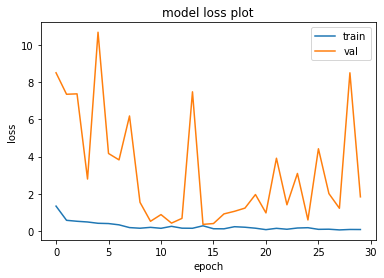

In [23]:
plt.plot(history.history['acc'], label='accuracy')
plt.plot(history.history['val_acc'], label = 'val_accuracy')
plt.title('model accuracy plot')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss plot')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='best')
plt.show()

In [24]:
print("Inference Time is", executionTime/60, "mins")

Inference Time is 65.25891411304474 mins


# Updated Solnet model

In [7]:
def SolNet_updated(in_size):
  i = Input(in_size)
  r = Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(227,227,3))(i)
  r = BatchNormalization()(r)
  r = MaxPooling2D(pool_size=(3,3), strides=(2,2))(r)
  r = Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same")(r)
  r = BatchNormalization()(r)
  r = MaxPooling2D(pool_size=(3,3), strides=(2,2))(r)
  r = Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same")(r)
  r = BatchNormalization()(r)
  r = Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same")(r)
  r = BatchNormalization()(r)
  r = Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same")(r)
  r = BatchNormalization()(r)
  r = MaxPooling2D(pool_size=(3,3), strides=(2,2))(r)
  r = Flatten()(r)
  r = Dense(4096, activation='relu')(r)
  r = Dropout(0.5)(r)
  r = Dense(4096, activation='relu')(r)
  r = Dropout(0.5)(r)
  o = Dense(1, activation='sigmoid')(r)


  SolNet = Model(inputs = i, outputs = o)



  SolNet.save('models/solnet.hdf5')
  SolNet.save('/content/drive/MyDrive/Solar_panel_dust_detection/models/solnet_updated_'+str(datetime.datetime.today().date())+'.hdf5')
  SolNet.save('/content/drive/MyDrive/Solar_panel_dust_detection/models/solnet_updated_'+str(datetime.datetime.today().date())+'.h5')
  SolNet.compile(optimizer=Adam(.00001), loss=binary_crossentropy, metrics=['acc'])
  SolNet.summary()
  return SolNet

In [8]:
batch_size = 32
#location = 'dataset/'
location = "/content/drive/MyDrive/Solar_panel_dust_detection/dataset_1"
label_mode = 'binary'
seed = 10 #changed for each fold made manually
epochs=20
#epochs=5


class_names = ['clean', 'dirty']
in_size = [180, 180, 3]

tr_dataset = image_dataset_from_directory(directory=location, label_mode= label_mode, class_names=class_names,
                                          seed=seed, labels='inferred', image_size=in_size[:-1], 
                                          subset = 'training', batch_size=batch_size, validation_split=.2)

val_dataset = image_dataset_from_directory(directory=location, label_mode= label_mode, class_names=class_names,
                                          seed=seed, labels='inferred', image_size=in_size[:-1],
                                          subset = 'validation', batch_size=batch_size, validation_split=.2)

# in_size = [227, 227, 3]
SolNet = SolNet_updated(in_size)



startTime = time.time()
history = SolNet.fit(tr_dataset, validation_data=val_dataset, epochs=epochs, batch_size=batch_size)
executionTime = (time.time() - startTime)

Found 1440 files belonging to 2 classes.
Using 1152 files for training.
Found 1440 files belonging to 2 classes.
Using 288 files for validation.


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 43, 43, 96)        34944     
                                                                 
 batch_normalization (BatchN  (None, 43, 43, 96)       384       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 21, 21, 96)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 21, 21, 256)       614656    
                                                                 
 batch_normalization_1 (Batc  (None, 21, 21, 256)      1024  

In [9]:
print("Inference Time is", executionTime/60, "mins")

Inference Time is 46.583025467395785 mins


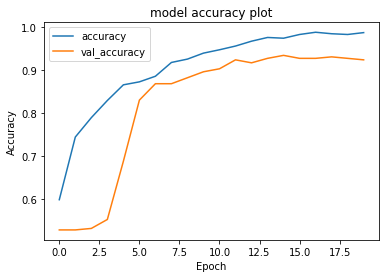

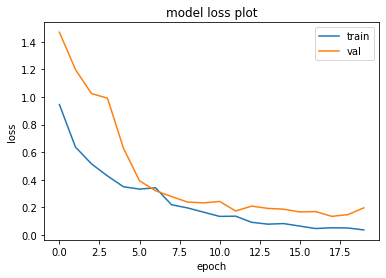

In [10]:
plt.plot(history.history['acc'], label='accuracy')
plt.plot(history.history['val_acc'], label = 'val_accuracy')
plt.title('model accuracy plot')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss plot')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='best')
plt.show()